## Flights sensitivity analysis

Run on bbsn00, use global specialized version (all files) vs. hyper per file. single-threaded to count execution time.

Run using `nohup ctest -R BasicInvocation.FlightsSen --verbose &`.

In [1]:
import pandas as pd

In [2]:
data_path = '../data/flights-sensitivity-results-bbsn00.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
def path_to_year(path):
    parts = path.replace('.csv', '').split('_')
    return pd.to_datetime(parts[-2] + '-' + parts[-1] + '-01')

In [5]:
gdf = df.groupby(['mode', 'path'])['time'].aggregate(['mean', 'std']).reset_index()
gdf['date'] = df['path'].apply(path_to_year)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.lines
import seaborn as sns
import json
import os

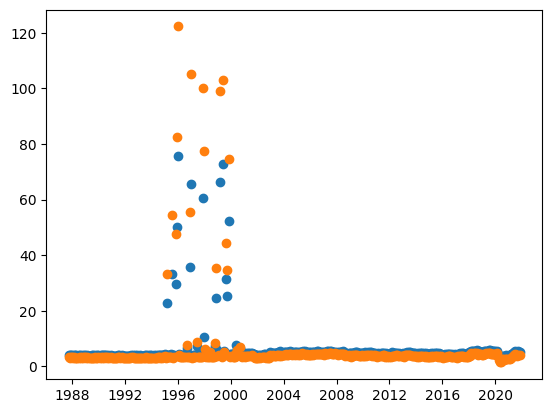

In [7]:
gdf_hyper = gdf[gdf['mode'] == 'hyper']
plt.scatter(gdf_hyper['date'], gdf_hyper['mean'], label='hyper')
gdf_global = gdf[gdf['mode'] == 'global']
plt.scatter(gdf_global['date'], gdf_global['mean'], label='global')

In [8]:
# now compute speedup factors


In [9]:
gdf = gdf.sort_values(by=['mode', 'date']).reset_index(drop=True)

In [10]:
speedups = gdf[gdf['mode'] == 'global']['mean'].values / gdf[gdf['mode'] == 'hyper']['mean'].values

In [11]:
sf_series = pd.Series(speedups, index=gdf[gdf['mode'] == 'hyper']['date'])

In [12]:
hyper_total_time = gdf[gdf['mode'] == 'hyper']['mean'].sum()
global_total_time = gdf[gdf['mode'] == 'global']['mean'].sum()

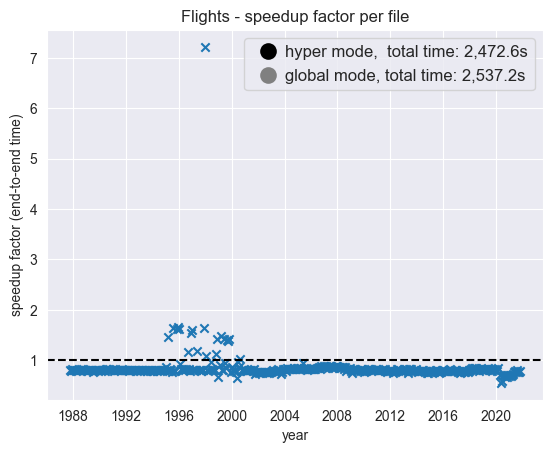

In [13]:
sns.set_style('darkgrid')
plt.scatter(sf_series.index, sf_series, marker='x')
plt.axhline(1, linestyle='--', color='k')
plt.xlabel('year')
plt.ylabel('speedup factor (end-to-end time)')
plt.title('Flights - speedup factor per file')

# add to legend total time
ax = plt.gca()
hlabels=[('hyper mode,  total time: {:,.1f}s'.format(hyper_total_time), 'k'),
         ('global mode, total time: {:,.1f}s'.format(global_total_time), [0.5, 0.5, 0.5])]
handles = []
for h in hlabels:
    handles.append(matplotlib.lines.Line2D([0], [0], marker='o', color='none', label=h[0],
                        markerfacecolor=h[1], markeredgecolor='none', markersize=12))
ax.legend(handles=handles, fontsize=12, handletextpad=0.05)

In [14]:
import numpy as np

Text(0, 0.5, 'speedup factor (end-to-end time)')

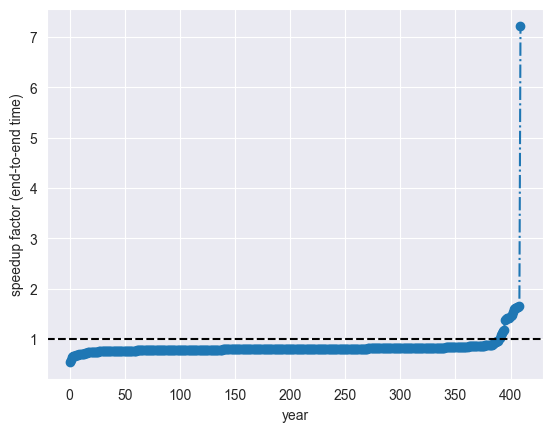

In [15]:
plt.plot(np.arange(len(sf_series)), sf_series.sort_values(), linestyle='-.', marker='o')
plt.axhline(1, linestyle='--', color='k')
plt.xlabel('year')
plt.ylabel('speedup factor (end-to-end time)')

In [16]:
#compute global speedup factor by adding up times

num_runs = df['run'].max() + 1
total_time = df.groupby(['mode'])['time'].sum() / num_runs
global_speedup = total_time.loc['global'] / total_time.loc['hyper']

In [17]:
df['input_row_count'] = df['stats'].apply(lambda x: json.loads(x)['input']['total_input_row_count'])
for k in ["fast_path_execution_time",
          "general_and_interpreter_time",
          "compile_time",
          "hyperspecialization_time"]:
    df[k] = df['stats'].apply(lambda x: json.loads(x)['timings'].get(k))

In [18]:
df['stats']

0       {"input":{"input_file_count":1,"total_input_ro...
1       {"input":{"input_file_count":1,"total_input_ro...
2       {"input":{"input_file_count":1,"total_input_ro...
3       {"input":{"input_file_count":1,"total_input_ro...
4       {"input":{"input_file_count":1,"total_input_ro...
                              ...                        
1153    {"input":{"input_file_count":1,"total_input_ro...
1154    {"input":{"input_file_count":1,"total_input_ro...
1155    {"input":{"input_file_count":1,"total_input_ro...
1156    {"input":{"input_file_count":1,"total_input_ro...
1157    {"input":{"input_file_count":1,"total_input_ro...
Name: stats, Length: 1158, dtype: object

In [19]:
mu_df = df.groupby(['mode', 'path']).mean().sort_values(by='input_row_count').reset_index()

/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_3719/2905200233.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mu_df = df.groupby(['mode', 'path']).mean().sort_values(by='input_row_count').reset_index()


In [20]:
mu_df['date'] = mu_df['path'].apply(path_to_year)

In [21]:
mu_df_global = mu_df[mu_df['mode'] == 'global']
mu_df_hyper = mu_df[mu_df['mode'] == 'hyper']

/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_3719/3850761765.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


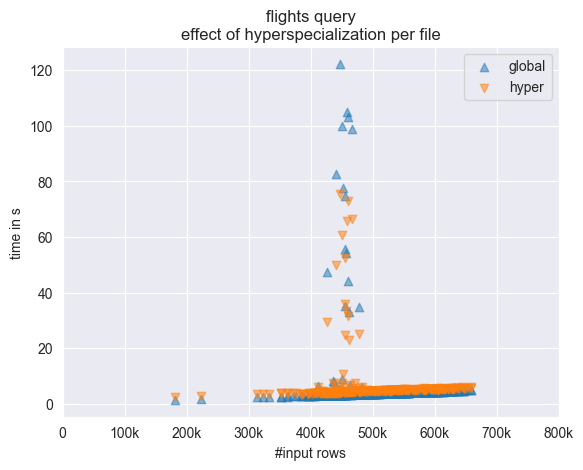

In [22]:
plt.scatter(mu_df_global['input_row_count'], mu_df_global['time'], marker='^', label='global', alpha=.5)
plt.scatter(mu_df_hyper['input_row_count'], mu_df_hyper['time'], marker='v', label='hyper', alpha=.5)
plt.xlabel('#input rows')
plt.xlim(0, 800 * 1000)
ax = plt.gca()
xlabels = ['{:,}'.format(int(x)) + 'k' if x != 0 else '0' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
plt.ylabel('time in s')
plt.legend(loc='best')
plt.title('flights query\neffect of hyperspecialization per file')

print()

In [23]:
mu_df_hyper = mu_df_hyper.sort_values(by='date').reset_index()

In [24]:
mu_df_hyper.head()

,index,mode,path,run,time,input_row_count,fast_path_execution_time,general_and_interpreter_time,compile_time,hyperspecialization_time,date
0,270,hyper,/hot/data/flights_all/flights_on_time_performa...,0.5,4.091120,448620.0,3.038840,0.091617,0.121628,0.700908,1987-10-01
1,92,hyper,/hot/data/flights_all/flights_on_time_performa...,0.5,3.985620,422803.0,2.863170,0.069537,0.119585,0.702372,1987-11-01
2,207,hyper,/hot/data/flights_all/flights_on_time_performa...,0.5,4.091035,440403.0,3.009575,0.073971,0.119532,0.701597,1987-12-01
3,188,hyper,/hot/data/flights_all/flights_on_time_performa...,0.5,3.978645,436950.0,2.972730,0.076215,0.119334,0.701712,1988-01-01
4,49,hyper,/hot/data/flights_all/flights_on_time_performa...,0.5,3.786675,412579.0,2.788265,0.070847,0.119683,0.703160,1988-02-01


/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_3719/3810341261.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


Text(0.5, 0.98, 'Flights - Hyper mode')

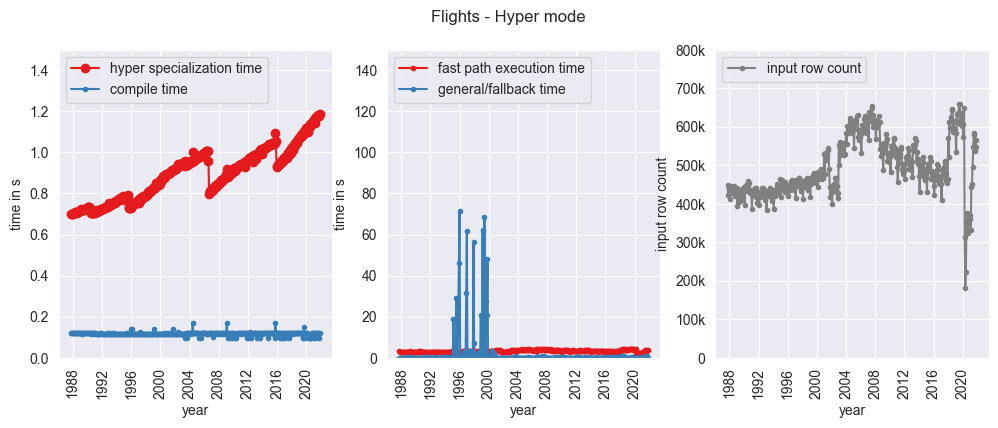

In [25]:
sns.set_palette(sns.color_palette("Set1"))

fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(mu_df_hyper['date'], mu_df_hyper['hyperspecialization_time'],
         marker='o', label='hyper specialization time')
plt.plot(mu_df_hyper['date'], mu_df_hyper['compile_time'], marker='.', label='compile time')

plt.legend(loc='best')
plt.ylim(0, 1.5)
plt.ylabel('time in s')
plt.xlabel('year')
plt.legend(loc='upper left')
plt.xticks(rotation=90)


plt.subplot(132)

plt.plot(mu_df_hyper['date'], mu_df_hyper['fast_path_execution_time'],
         marker='.', label='fast path execution time')
plt.plot(mu_df_hyper['date'], mu_df_hyper['general_and_interpreter_time'],
         marker='.', label='general/fallback time')
plt.xlabel('year')
plt.ylabel('time in s')
plt.legend(loc='upper left')
plt.ylim(0, 150)
plt.xticks(rotation=90)


plt.subplot(133)
plt.plot(mu_df_hyper['date'], mu_df_hyper['input_row_count'],
         marker='.', label='input row count', color=[0.5, 0.5, 0.5])
plt.ylim(0, 800 * 1000)
ax = plt.gca()
ylabels = ['{:}'.format(int(y)) + 'k' if y != 0 else '0' for y in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
plt.ylabel('input row count')
plt.xlabel('year')
plt.legend(loc='upper left')
plt.xticks(rotation=90)

fig.suptitle('Flights - Hyper mode')

In [26]:
mu_df_global = mu_df_global.sort_values(by='date').reset_index()

/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_3719/2868818923.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


Text(0.5, 0.98, 'Flights - Global mode')

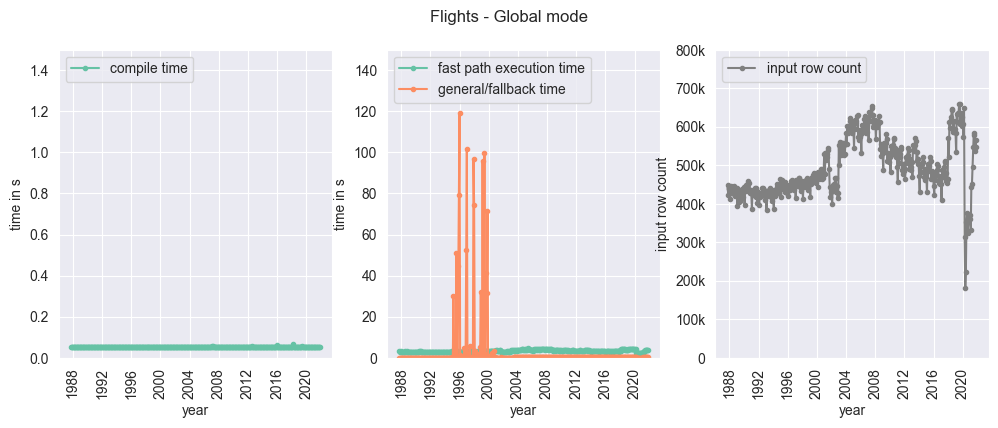

In [27]:
sns.set_palette(sns.color_palette("Set2"))
fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(mu_df_global['date'], mu_df_global['compile_time'], marker='.', label='compile time')

plt.legend(loc='best')
plt.ylim(0, 1.5)
plt.ylabel('time in s')
plt.xlabel('year')
plt.legend(loc='upper left')
plt.xticks(rotation=90)

plt.subplot(132)

plt.plot(mu_df_hyper['date'], mu_df_global['fast_path_execution_time'],
         marker='.', label='fast path execution time')
plt.plot(mu_df_hyper['date'], mu_df_global['general_and_interpreter_time'], marker='.',
         label='general/fallback time')
plt.xlabel('year')
plt.ylabel('time in s')
plt.legend(loc='upper left')
plt.ylim(0, 150)
plt.xticks(rotation=90)

plt.subplot(133)
plt.plot(mu_df_global['date'], mu_df_global['input_row_count'],
         marker='.', label='input row count', color=[0.5, 0.5, 0.5])
plt.ylim(0, 800 * 1000)
ax = plt.gca()
ylabels = ['{:}'.format(int(y)) + 'k' if y != 0 else '0' for y in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
plt.ylabel('input row count')
plt.xlabel('year')
plt.legend(loc='upper left')
plt.xticks(rotation=90)

fig.suptitle('Flights - Global mode')